In [ ]:
import os

os.system("pip install -r datasets/src/requirements.txt")
os.system("pip install seaborn")


In [ ]:
import os

os.system("pip install git+https://github.com/open-mmlab/cocoapi.git#subdirectory=pycocotools")


In [ ]:
import os

os.chdir("datasets/src/")
os.system("python setup.py develop")
os.chdir("../")

In [6]:
import requests

url = "https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/cascade_rcnn/cascade_rcnn_r50_fpn_20e_coco/cascade_rcnn_r50_fpn_20e_coco_bbox_mAP-0.41_20200504_175131-e9872a90.pth"
response = requests.get(url)

with open("cascade_rcnn_r50_fpn_20e_coco_bbox_mAP-0.41_20200504_175131-e9872a90.pth", "wb") as f:
    f.write(response.content)


In [1]:
import json
with open("datasets/mini_airplane/annotations/mini_airplane_train.json", "r") as f:
    labels = json.load(f)
imagename2id = {}
imageid2anno = {}
imagename2imageinfo = {}
for image in labels["images"]:
    imagename2id[image["file_name"]] = image["id"]
    imagename2imageinfo[image["file_name"]] = image
for anno in labels["annotations"]:
    if anno["image_id"] not in imageid2anno:
        imageid2anno[anno["image_id"]] = []
    imageid2anno[anno["image_id"]].append(anno)

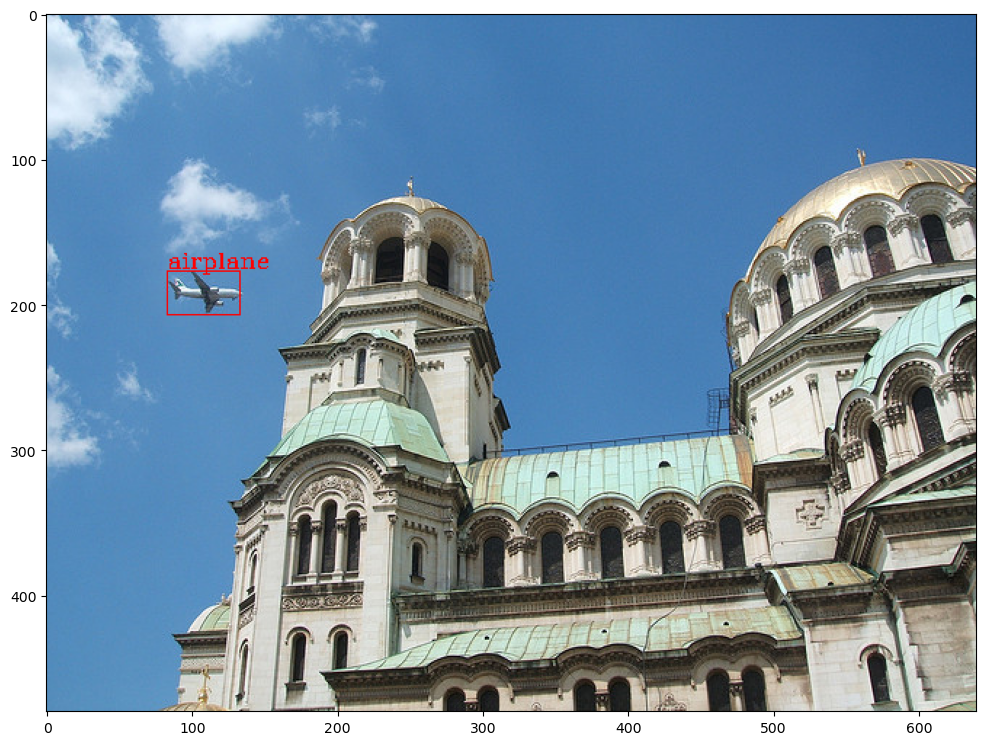

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) 
import cv2
import numpy as np
img = cv2.imread('datasets/mini_airplane/images/COCO_val2014_000000253223.jpg')
annos = imageid2anno[imagename2id['COCO_val2014_000000253223.jpg']]
bboxes = []
for anno in annos:
    bboxes.append(anno["bbox"])
for det in bboxes:
    bbox = np.array(det[:4]).astype(int)
    cv2.rectangle(img, (bbox[0],bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), (0,0,255), 1)
    label_text = str("airplane")
    cv2.putText(img, label_text, (bbox[0], bbox[1] - 2),
            cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,0,255))
im2 = img[:,:,::-1] 
plt.imshow(im2)
plt.show()

In [3]:
import numpy as np
np.random.seed(123)
train_image_names = np.random.choice(list(imagename2id.keys()), int(len(imagename2id.keys())*0.8), False)
val_image_names = list(set(imagename2id.keys()) - set(train_image_names))
print("train_image_names lenght: ", len(train_image_names))
print("val_image_names lenght: ", len(val_image_names))

train_image_names lenght:  79
val_image_names lenght:  20


In [4]:
train_images = []
train_annotations = []
for imgname in train_image_names:
    train_images.append(imagename2imageinfo[imgname])
    image_id = imagename2id[imgname]
    train_annotations.extend(imageid2anno[image_id])
train_instance = {
    "images": train_images,
    "annotations": train_annotations,
    "categories": labels["categories"]
}
with open("datasets/mini_airplane/annotations/train.json", "w") as f:
    json.dump(train_instance, f, indent=2)
val_images = []
val_annotations = []
for imgname in val_image_names:
    val_images.append(imagename2imageinfo[imgname])
    image_id = imagename2id[imgname]
    val_annotations.extend(imageid2anno[image_id])
val_instance = {
    "images": val_images,
    "annotations": val_annotations,
    "categories": labels["categories"]
}
with open("datasets/mini_airplane/annotations/val.json", "w") as f:
    json.dump(val_instance, f, indent=2)

In [5]:
with open("datasets/src/configs/cascade_rcnn/cascade_rcnn_r50_fpn_1x_coco.py", "r") as f:
    content = f.read()
    print(content)


_base_ = [
    '../_base_/models/cascade_rcnn_r50_fpn.py',
    '../_base_/datasets/coco_detection.py',
    '../_base_/schedules/schedule_1x.py', '../_base_/default_runtime.py'
]



In [8]:
model = dict(
    type='CascadeRCNN', # 这里首先声明我们要使用的模型类型是CascadeRCNN
    pretrained='torchvision://resnet50',  # 这里说明backbone部分将会使用的预训练模型的权重路径，注意这个仅仅是backbone部分的权重
    backbone=dict(
        type='ResNet', # backbone类型为resnet
        depth=50, # 层数为，即resnet50
        num_stages=4, # resnet50 一共有4个stage
        out_indices=(0, 1, 2, 3), # 4个stage 中的哪些stage用于输出，这里使用标准的FPN，所以4个stage都输出
        frozen_stages=1, # 参数冻结的stage，意思是包括第一个stage及其之前的参数都冻结，不更新
        norm_cfg=dict(type='BN', requires_grad=True), # 训练使用BN
        norm_eval=True,
        style='pytorch'), # 网络类型为pytorch，主要为了和caffe区分，因为他们图片标准化形式不同
    neck=dict( # neck网络
        type='FPN', # 采用FPN 
        in_channels=[256, 512, 1024, 2048], # FPN输入为backbone的4个stage输出，各自的通道数为[256, 512, 1024, 2048]
        out_channels=256, # FPN输出的特征图通道数
        num_outs=5), # FPN一共输出的特征图数量，其中有一个是额外上采样得到
        rpn_head=dict( # RPN 网络的head结构
        type='RPNHead',
        in_channels=256, # 输入通道数
        feat_channels=256, # 中间特征的通道数
        anchor_generator=dict( # 定义anchor生成的参数
            type='AnchorGenerator', 
            scales=[8], # anchor的基础大小为8
            ratios=[0.5, 1.0, 2.0],  #anchor长宽比例的平方值
            strides=[4, 8, 16, 32, 64]), # anchor分布在5个FPN输出上的stride
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder', # bbox编码的方式
            target_means=[.0, .0, .0, .0], #编码的均值
            target_stds=[1.0, 1.0, 1.0, 1.0]), #编码的方差
        loss_cls=dict( # RPN的分类loss
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0), # CE loss
        loss_bbox=dict(type='L1Loss', loss_weight=1.0)), # 回归loss
        roi_head=dict( # roi检测器结构 这里定义了cascade的核心部分
        type='CascadeRoIHead',# 定义ROI Head结构为CascadeRoIHead
        num_stages=3, # 采用三个stage级联
        stage_loss_weights=[1, 0.5, 0.25], # 每个stage的loss权重
        bbox_roi_extractor=dict( # 每个stage的检测器输入下一个stage前重新提取proposal特征使用的特征提取器
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0), # 采用RoIAlign，输出特征图大小为7*7
            out_channels=256, # 输出的特征图通道为256
            featmap_strides=[4, 8, 16, 32]), # 特征图的不同下采样率（对应resnet backbone中4个stage）
                    bbox_head=[ # 三个stage中head的结构
            dict( # 第一个stage
                type='Shared2FCBBoxHead', # 采用两个全连接的head
                in_channels=256, # 输入通道数为256，对应上面bbox_roi_extractor输出通道数
                fc_out_channels=1024,
                roi_feat_size=7, # 输入的roi 特征图大小为7*7，对应上面RoIAlign，输出特征图大小为7*7
                num_classes=80, # 类别数量为80，COCO有80类
                bbox_coder=dict( # 边界框坐标编码形式
                    type='DeltaXYWHBBoxCoder',
                    target_means=[0., 0., 0., 0.],
                    target_stds=[0.1, 0.1, 0.2, 0.2]),
                reg_class_agnostic=True, # 这是比较重要的一点，cascade中坐标回归分支不考虑类别，仅考虑前景背景二分类
                loss_cls=dict( # loss
                    type='CrossEntropyLoss',
                    use_sigmoid=False,
                    loss_weight=1.0),
                loss_bbox=dict(type='SmoothL1Loss', beta=1.0,
                               loss_weight=1.0)),
                                   dict(
                type='Shared2FCBBoxHead',  # 第二个stage同第一个
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                num_classes=80,
                bbox_coder=dict(
                    type='DeltaXYWHBBoxCoder',
                    target_means=[0., 0., 0., 0.],
                    target_stds=[0.05, 0.05, 0.1, 0.1]),
                reg_class_agnostic=True,
                loss_cls=dict(
                    type='CrossEntropyLoss',
                    use_sigmoid=False,
                    loss_weight=1.0),
                loss_bbox=dict(type='SmoothL1Loss', beta=1.0,
                               loss_weight=1.0)),
                                    dict(
                type='Shared2FCBBoxHead', # 第三个stage同第一个
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                num_classes=80,
                bbox_coder=dict(
                    type='DeltaXYWHBBoxCoder',
                    target_means=[0., 0., 0., 0.],
                    target_stds=[0.033, 0.033, 0.067, 0.067]),
                reg_class_agnostic=True,
                loss_cls=dict(
                    type='CrossEntropyLoss',
                    use_sigmoid=False,
                    loss_weight=1.0),
                loss_bbox=dict(type='SmoothL1Loss', beta=1.0, loss_weight=1.0))
        ]))
# model training and testing settings
train_cfg = dict(
    rpn=dict( # rpn的配置
        assigner=dict( # anchor和gt的匹配器
            type='MaxIoUAssigner',  # 匹配方式
            pos_iou_thr=0.7, #正样本阈值
            neg_iou_thr=0.3, #负样本阈值
            min_pos_iou=0.3,
            match_low_quality=True,
            ignore_iof_thr=-1),
        sampler=dict( #匹配之后采样的方式
            type='RandomSampler', #随机采样
            num=256, #采样个数
            pos_fraction=0.5, #采样正样本比例
            neg_pos_ub=-1,
            add_gt_as_proposals=False),
        allowed_border=-1,
        pos_weight=-1,
        debug=False),
    rpn_proposal=dict( # rpn的proposal的预测配置
        nms_across_levels=False, #是否逐fpn层nms
        nms_pre=2000, # nms前proposal数量
        nms_post=1000, # nms后的proposal数量
        max_num=1000, # 最终保留的proposal数量
        nms_thr=0.7, # nms阈值
        min_bbox_size=0), 
    rcnn=[ # 3个stage 训练参数设置
        dict(  # 第一个stage 
            assigner=dict( # proposal和gt的匹配方式
                type='MaxIoUAssigner', #采用MaxIoU匹配
                pos_iou_thr=0.5, # 正负样本阈值为0.5
                neg_iou_thr=0.5,
                min_pos_iou=0.5,
                match_low_quality=False,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler', #随机采样
                num=512, #采样数量为512
                pos_fraction=0.25, #正样本比例为0.25
                neg_pos_ub=-1, 
                add_gt_as_proposals=True),
            pos_weight=-1,
            debug=False),
        dict( # 第二个stage
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.6, # 正负样本阈值提高为0.6
                neg_iou_thr=0.6,
                min_pos_iou=0.6,
                match_low_quality=False,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=512,
                pos_fraction=0.25,
                neg_pos_ub=-1,
                add_gt_as_proposals=True),
            pos_weight=-1,
            debug=False),
        dict( #第三个stage
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.7, # 正负样本阈值提高为0.7
                neg_iou_thr=0.7,
                min_pos_iou=0.7,
                match_low_quality=False,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=512,
                pos_fraction=0.25,
                neg_pos_ub=-1,
                add_gt_as_proposals=True),
            pos_weight=-1,
            debug=False)
    ])
test_cfg = dict( #测试配置
    rpn=dict(
        nms_across_levels=False, # 是否跨FPN层nms 
        nms_pre=1000, # nms 前的proposal数量
        nms_post=1000,# nms 后数量
        max_num=1000, # 最终输入到roi head中的最多的proposal数量
        nms_thr=0.7, # nms iou阈值
        min_bbox_size=0),
    rcnn=dict( # 最终结果后处理的配置，包括后处理类别和阈值
        score_thr=0.05, nms=dict(type='nms', iou_thr=0.5), max_per_img=100) # 采用nms，iou阈值为0.5，score阈值为0.05，每张图至多检测100个目标
)

In [9]:
dataset_type = 'CocoDataset' # 数据集类型
data_root = 'data/coco/' # 数据根目录
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True) # 用于图片归一化的均值和方差
train_pipeline = [  # 训练数据处理的流水线
    dict(type='LoadImageFromFile'), #加载图片
    dict(type='LoadAnnotations', with_bbox=True),  #加载label
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),  #训练的尺度
    dict(type='RandomFlip', flip_ratio=0.5), # 训练在线随机翻转
    dict(type='Normalize', **img_norm_cfg),  # 图片归一化
    dict(type='Pad', size_divisor=32), #图片pad到长宽均为32的倍数
    dict(type='DefaultFormatBundle'), 
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
]
test_pipeline = [ # 测试数据处理的流水线
    dict(type='LoadImageFromFile'),#加载图片
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800), #训练的尺度
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),#resize图片
            dict(type='RandomFlip'), #预测时候 TTA翻转
            dict(type='Normalize', **img_norm_cfg),# 图片归一化
            dict(type='Pad', size_divisor=32),#图片pad到长宽均为32的倍数
            dict(type='ImageToTensor', keys=['img']), #图片转换为pytorch tensor格式
            dict(type='Collect', keys=['img']),
        ])
]
data = dict(
    imgs_per_gpu=2, # 每个显卡的batchsize，总batchszie=imgs_per_gpu*gpu_nums
    workers_per_gpu=2, # 多进程数量
    train=dict(
        type=dataset_type, 
        ann_file=data_root + 'annotations/instances_train2017.json', #训练集label路径
        img_prefix=data_root + 'train2017/', #训练集图片路径
        pipeline=train_pipeline),
    val=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations/instances_val2017.json', #验证集label路径
        img_prefix=data_root + 'val2017/', #验证集图片路径
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
        ann_file=data_root + 'annotations/instances_val2017.json',#测试集label路径
        img_prefix=data_root + 'val2017/',#测试集图片路径
        pipeline=test_pipeline))
evaluation = dict(interval=1, metric='bbox') # 训练时候每个epoch进行验证，验证的内容针对bbox label

In [10]:
# optimizer
optimizer = dict(type='SGD', lr=0.02, momentum=0.9, weight_decay=0.0001) #优化器设置，一般lr设置为 0.02*batchsize/16
optimizer_config = dict(grad_clip=None) # 对梯度进行裁剪，保证梯度不过大引发训练震荡
# learning policy
lr_config = dict(  
    policy='step', 
    warmup='linear',  # 学习率 warm up
    warmup_iters=500, # warm up的步数
    warmup_ratio=1.0 / 3,
    step=[8, 11]) # 8 和 11epoch时候降低学习率*0.1
total_epochs = 12 # 训练的epoch数量

In [11]:
checkpoint_config = dict(interval=1)  # 多少epoch保存一次模型

log_config = dict(
    interval=50,  #打印log的频率
    hooks=[
        dict(type='TextLoggerHook'), # text保存log
        # dict(type='TensorboardLoggerHook') # tensorboard 保存log
    ])
dist_params = dict(backend='nccl') # 采用nccl为backend
log_level = 'INFO' #log的等级为INFO
load_from = None # 用于加载一些预训练模型，例如COCO预训练模型的路径，注意这个和上面的pretrain的区别是除了backbone部分，其他match的也加载
resume_from = None # 用于模型resume的模型路径
workflow = [('train', 1)] 

In [12]:
model=dict(pretrained=None,
     roi_head=dict(bbox_head=[
      dict(
          type='Shared2FCBBoxHead',
          in_channels=256,
          fc_out_channels=1024,
          roi_feat_size=7,
          num_classes=1,
          bbox_coder=dict(
              type='DeltaXYWHBBoxCoder',
              target_means=[0., 0., 0., 0.],
              target_stds=[0.1, 0.1, 0.2, 0.2]),
          reg_class_agnostic=True,
          loss_cls=dict(
              type='CrossEntropyLoss',
              use_sigmoid=False,
              loss_weight=1.0),
          loss_bbox=dict(type='SmoothL1Loss', beta=1.0,
                         loss_weight=1.0)),
               dict(
          type='Shared2FCBBoxHead',
          in_channels=256,
          fc_out_channels=1024,
          roi_feat_size=7,
          num_classes=1,
          bbox_coder=dict(
              type='DeltaXYWHBBoxCoder',
              target_means=[0., 0., 0., 0.],
              target_stds=[0.05, 0.05, 0.1, 0.1]),
          reg_class_agnostic=True,
          loss_cls=dict(
              type='CrossEntropyLoss',
              use_sigmoid=False,
              loss_weight=1.0),
          loss_bbox=dict(type='SmoothL1Loss', beta=1.0,
                         loss_weight=1.0)),
               dict(
          type='Shared2FCBBoxHead',
          in_channels=256,
          fc_out_channels=1024,
          roi_feat_size=7,
          num_classes=1,
          bbox_coder=dict(
              type='DeltaXYWHBBoxCoder',
              target_means=[0., 0., 0., 0.],
              target_stds=[0.033, 0.033, 0.067, 0.067]),
          reg_class_agnostic=True,
          loss_cls=dict(
              type='CrossEntropyLoss',
              use_sigmoid=False,
              loss_weight=1.0),
          loss_bbox=dict(type='SmoothL1Loss', beta=1.0, loss_weight=1.0))
  ]))

In [13]:
data_root = 'datasets/mini_airplane/'

In [16]:
classes = ('airplane', )

In [17]:
data = dict(
samples_per_gpu=1,
train=dict(classes=classes, ann_file=data_root + 'annotations/train.json', img_prefix=data_root + 'images/',),
val=dict(classes=classes, ann_file=data_root + 'annotations/val.json', img_prefix=data_root + 'images/',),
test=dict(classes=classes, ann_file=data_root + 'annotations/val.json', img_prefix=data_root + 'images/',))

In [18]:
optimizer = dict(type='SGD', lr=0.00125, momentum=0.9, weight_decay=0.0001)

In [19]:
lr_config = dict(
  policy='step',
  warmup='linear',
  warmup_iters=10,
  warmup_ratio=0.001,
  step=[2, 3])

In [20]:
total_epochs = 4

In [21]:
log_config = dict(
interval=5,
hooks=[
  dict(type='TextLoggerHook'),
  # dict(type='TensorboardLoggerHook')
])

In [22]:
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'cascade_rcnn_r50_fpn_20e_coco_bbox_mAP-0.41_20200504_175131-e9872a90.pth' # load COCO预训练模型
resume_from = None
workflow = [('train', 1)]

In [23]:
with open("datasets/src/configs/cascade_rcnn/cascade_rcnn_r50_fpn_1x_coco.py", "r") as f:
    content = f.read()
    print(content)


_base_ = [
    '../_base_/models/cascade_rcnn_r50_fpn.py',
    '../_base_/datasets/coco_detection.py',
    '../_base_/schedules/schedule_1x.py', '../_base_/default_runtime.py'
]



In [24]:
import os

os.system("python datasets/src/tools/train.py src/configs/cascade_rcnn/cascade_rcnn_r50_fpn-airplane.py")


1

In [25]:
import os

os.system("ls datasets/models/cascade_rcnn_r50_fpn-airplane/")


1

In [26]:
import os

os.system("python datasets/src/tools/test.py src/configs/cascade_rcnn/cascade_rcnn_r50_fpn-airplane.py datasets/models/cascade_rcnn_r50_fpn-airplane/epoch_4.pth --eval bbox")


1

In [27]:
import os

os.system("python datasets/src/tools/test.py datasets/src/configs/cascade_rcnn/cascade_rcnn_r50_fpn-airplane.py datasets/models/cascade_rcnn_r50_fpn-airplane/epoch_4.pth --show")


1

In [28]:
import os

os.system("python datasets/src/tools/analyze_logs.py plot_curve datasets/models/cascade_rcnn_r50_fpn-airplane/20200714_124242.log.json --keys lr --out results/cascade_rcnn_airplane_lr.jpg")


1

In [29]:
import os

os.system("python datasets/src/tools/analyze_logs.py plot_curve datasets/models/cascade_rcnn_r50_fpn-airplane/20200714_124242.log.json --keys loss_rpn_cls loss_rpn_bbox s0.loss_cls s0.acc s0.loss_bbox s1.loss_cls s1.acc s1.loss_bbox s2.loss_cls s2.acc s2.loss_bbox --out results/cascade_rcnn_airplane-losses.jpg")


1

In [30]:
import os

os.system("python datasets/src/tools/analyze_logs.py plot_curve datasets/models/cascade_rcnn_r50_fpn-airplane/20200714_124242.log.json --keys bbox_mAP --out results/cascade_rcnn_airplane_map.jpg")


1